# Convolutional Neural Networks
## Gathering Data

In [10]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

REBUILD_DATA = True

In [2]:
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "CatsDogs\PetImages\Cat"
    DOGS = "CatsDogs\PetImages\Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    cat_count = 0
    dog_count = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                        if label == self.CATS:
                            self.cat_count += 1                    
                        elif label == self.DOGS:
                            self.dog_count += 1
                    except Exception as e:
                        pass
    
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.cat_count)
        print("Dogs: ", self.dog_count)
    
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

100%|██████████| 12501/12501 [00:30<00:00, 410.57it/s]
C:\Users\Kartik\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Cats:  12476
Dogs:  12470


In [4]:
training_data = np.load("training_data.npy", allow_pickle = True)

In [5]:
print(len(training_data))

24946


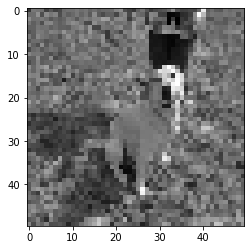

In [14]:
img, label = training_data[1]
plt.imshow(img, cmap = 'gray')

## Building the Convnet

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [23]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * \
                              x[0].shape[1] * \
                              x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
        
net = Net()

# Training the Convnet

In [24]:
import torch.optim as optim

In [25]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [26]:
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [27]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [28]:
print(len(train_X), len(test_X))

22452 2494


In [51]:
BATCH_SIZE = 50
EPOCHS = 10

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

  0%|          | 1/450 [00:00<01:05,  6.82it/s]

Epoch: 0. Loss: 0.0001786711363820359


  0%|          | 1/450 [00:00<01:07,  6.61it/s]

Epoch: 1. Loss: 0.00013067109102848917


  0%|          | 1/450 [00:00<01:10,  6.41it/s]

Epoch: 2. Loss: 0.000203383038751781


  0%|          | 1/450 [00:00<01:20,  5.56it/s]

Epoch: 3. Loss: 3.923859549104236e-05


  0%|          | 1/450 [00:00<01:06,  6.74it/s]

Epoch: 4. Loss: 2.2607509890804067e-06


  0%|          | 1/450 [00:00<01:01,  7.28it/s]

Epoch: 5. Loss: 5.252011305856286e-06


  0%|          | 1/450 [00:00<01:03,  7.12it/s]

Epoch: 6. Loss: 3.2932621252257377e-06


  0%|          | 1/450 [00:00<01:02,  7.19it/s]

Epoch: 7. Loss: 4.4626563067140523e-07


  0%|          | 1/450 [00:00<01:02,  7.22it/s]

Epoch: 8. Loss: 3.263590770075098e-05


100%|██████████| 450/450 [01:04<00:00,  6.94it/s]


Epoch: 9. Loss: 0.0014368196716532111


In [72]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: %.2f" %(100*correct/total))

100%|██████████| 2494/2494 [00:04<00:00, 568.33it/s]

Accuracy: 77.19


# Testing the Convnet

In [53]:
testset = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)

Enter the seed: 2
Label: Cat
Predicition: Cat


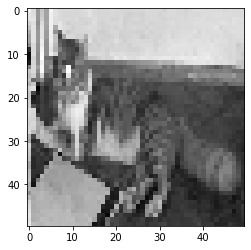

In [78]:
seed = input("Enter the seed: ")
img, label = training_data[int(seed)]
plt.imshow(img, cmap = 'gray')
if label[0] == 1:
    print("Label: Cat")
else:
    print("Label: Dog")
    
prediction = net(testset[int(seed)].view(-1, 1, 50, 50))[0]
predicted_class = torch.argmax(prediction)
if predicted_class == 1:
    print("Predicition: Dog")
else:
    print("Predicition: Cat")